## 作業

請參考昨天的程式碼，訓練資料讀取的方式改寫成 Python Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。

## 參考資料

[The Sequential model API](https://keras.io/models/sequential/)

[Keras系列 - 利用 fit_generator 最小化显存占用比率/数据批次化](https://blog.csdn.net/sinat_26917383/article/details/74922230)

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
tf.logging.set_verbosity(tf.logging.ERROR)

## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 10)


## 定義函數

In [6]:
def image_generator(x, y, batch_size=32):
    total = x.shape[0]
    idx_list = np.arange(total)
    while True:
        np.random.shuffle(idx_list)
        idx_matrix = [idx_list[i * batch_size:(i + 1) * batch_size] for i in range(int(math.ceil(total / batch_size)))]
        for idx_list in idx_matrix:
            yield x[idx_list], y[idx_list]

class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=128, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        return RMSprop(lr=self.learning_rate)

    @property
    def generator(self):
        return image_generator(*self.train_data, self.batch_size)

    @property
    def train_data(self):
        return (self.X_train, self.y_train,)

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        model = self._model = Sequential()
        model.add(Conv2D(32, (3, 3,), input_shape=self.X_train.shape[1:]))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.15))
        model.add(Conv2D(64, (3, 3,)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.15))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.10))
        model.add(Dense(self.y_train.shape[-1]))
        model.add(Activation('softmax'))
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with trainer: {}'.format(self.__class__.__name__))
        self._model.summary()
        self._history = self._model.fit_generator(
            self.generator, epochs=self.epochs, steps_per_epoch=int(math.ceil(self.X_train.shape[0] / self.batch_size)),
            validation_data=self.validation_data, verbose=2)
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(8, 6,))
        plt.plot(self._history.history[train_name])
        plt.plot(self._history.history[val_name])
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## 訓練模型

In [7]:
trainer = Trainer(X_train, y_train, X_test, y_test).run()

Experiment with trainer: Trainer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12,

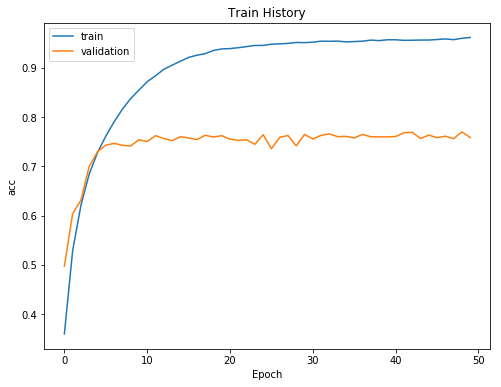

In [8]:
trainer.display('acc', 'val_acc')

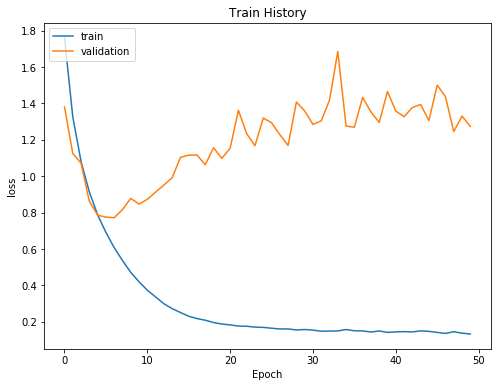

In [9]:
trainer.display('loss', 'val_loss')